## Global Black Box Optimization with RNNS

In [1]:
import tensorflow as tf
import numpy as np
import visualize as viz
import benchmarkfunctions as bf
import matplotlib.pyplot as plt

In [2]:
def kernel(x1,x2):
    return np.exp(-1.0/l**2*np.sum((np.expand_dims(x1,axis=2) - np.expand_dims(x2,axis=1))**2, axis = 3))

def GP(X,A,x):
    k_xX = kernel(x,X)
    return np.squeeze(np.matmul(k_xX,  A),axis=(2,))

def kernelTF(x1,x2):
    return tf.exp(-1.0/l**2*tf.reduce_sum((tf.expand_dims(x1,axis=2) - tf.expand_dims(x2,axis=1))**2, axis = 3))

def GPTF(X,A,x):
    k_xX = kernelTF(tf.expand_dims(x, axis = 1),X)
    return tf.squeeze(tf.matmul(k_xX,  A),axis=(2,))

def normalize(minv, maxv, y):
    return 2*(y-minv)/(maxv-minv)-1.0

In [3]:
def gen_data(n_train, n_test, dim, n_bumps, n_mc_samples = 100):
    X = np.random.uniform(low = -1.0, high = 1.0, size = (n_train+n_test, n_bumps, dim))
    Y = np.random.uniform(low = -1.0, high = 1.0, size = (n_train+n_test, n_bumps))

    K_XX = kernel(X,X)
    A = np.linalg.solve(K_XX, np.expand_dims(Y,axis=2))
    
    mc_samples = np.random.uniform(low = -1.0, high = 1.0, size = [1, n_mc_samples, dim])
    y = GP(X,A,mc_samples)

    min_vals = np.min(y, axis = 1).reshape(n_train+n_test,1)
    max_vals = np.max(y, axis = 1).reshape(n_train+n_test,1)

    return (X[:n_train], A[:n_train], min_vals[:n_train], max_vals[:n_train],\
            X[-n_test:], A[-n_test:], min_vals[-n_test:], max_vals[-n_test:])

In [4]:
def lstm_model(f, cell, weights):
    
    x_0 = -0.0*tf.ones([size, dim])
    h_0 = tf.ones([size, n_hidden])
    c_0 = tf.ones([size, n_hidden])
 
    state = (c_0, h_0)
    x = x_0
    y = f(x)+stddev*tf.random_normal([size, 1])
    samples_x = [x]
    samples_y = [y]

    for i in range(n_steps):
        h, state = cell(tf.concat([x, y], 1), state, scope='rnn_cell')
        x = tf.tanh(tf.matmul(h, weights['W_x']) + weights['b_x'])
        y = f(x)+stddev*tf.random_normal([size, 1])
        
        samples_x.append(x)
        samples_y.append(y)
    
    return samples_x, samples_y

In [5]:
def train_model(epochs, batch_size, log = True, verbose = True):
    
    if log:
        train_loss_list = []
        test_loss_list = []
        train_fmin_list = []
        test_fmin_list = []
    
    if verbose:
        print("Function Dimension: \t\t"+str(dim))
        print("Number of Training Samples: \t"+str(n_train))
        print("Number of Test Samples: \t"+str(n_test))
        print("Batch size: \t\t\t"+str(batch_size))
        print("Number of hidden Units: \t"+str(n_hidden))
        print("Sequence length: \t\t"+ str(n_steps))
        print("Noise in Observation: \t\t"+ str(stddev))
        print("Loss-Function: \t\t\t" + loss_type)
        print("Epochs: \t\t\t"+str(epochs))
        print("Learning rate init: \t\t"+str(rate_init))
        print("Learning rate decay: \t\t"+str(rate_decay))
        print("------------------------------------------------------------------------------------")

    learning_rate = rate_init
    for ep in range(epochs):
        learning_rate *= rate_decay
        
        for batch in range(n_train//batch_size):
            X_batch = X_train[batch*batch_size:(batch+1)*batch_size]
            A_batch = A_train[batch*batch_size:(batch+1)*batch_size]
            min_batch = min_train[batch*batch_size:(batch+1)*batch_size]
            max_batch = max_train[batch*batch_size:(batch+1)*batch_size]

            sess.run([train_step],\
                     feed_dict={Xt: X_batch, At: A_batch, mint: min_batch, maxt: max_batch,\
                                rate: learning_rate, size: X_batch.shape[0]})

        if log:
            train_loss, train_fmin = sess.run([loss, f_min], feed_dict=\
                                              {Xt: X_train, At: A_train, mint: min_train, maxt: max_train, size: n_train})
            test_loss, test_fmin = sess.run([loss, f_min], feed_dict=\
                                              {Xt: X_test, At: A_test, mint: min_test, maxt: max_test, size:n_test})
            train_loss_list += [train_loss]
            test_loss_list += [test_loss]
            train_fmin_list += [train_fmin]
            test_fmin_list += [test_fmin]

        if log and verbose and (ep < 10 or ep % (epochs // 10) == 0 or ep == epochs-1):
            print("Ep: " +"{:4}".format(ep)+" | TrainLoss: "+"{: .3f}".format(train_loss)
                  +" | TrainMin: "+ "{: .3f}".format(train_fmin)+ " | TestLoss: "+
                  "{: .3f}".format(test_loss)+" | TestMin: "+ "{: .3f}".format(test_fmin))
    
    print("Done.")
    if log:
        return (train_loss_list, test_loss_list, train_fmin_list, test_fmin_list)
    return None

In [6]:
# Data
dim = 2
n_train = 1600
n_test = 160
n_bumps = 3
l = 1/n_bumps*np.sqrt(dim)
n_mc_samples = 1000

# LSTM Model
n_hidden = 50
n_steps = 10

# Optimization
epochs = 1000

rate_init = 0.001
rate_final = 0.00001
rate_decay = (rate_final/rate_init)**(1/epochs)
batch_size = 128
stddev = 0.00
loss_type = ["MIN", "SUM", "WSUM", "EI"][2]

# Visualization
visualize = True

In [7]:
X_train, A_train, min_train, max_train, X_test, A_test, min_test, max_test = \
                                    gen_data(n_train, n_test, dim, n_bumps, n_mc_samples)

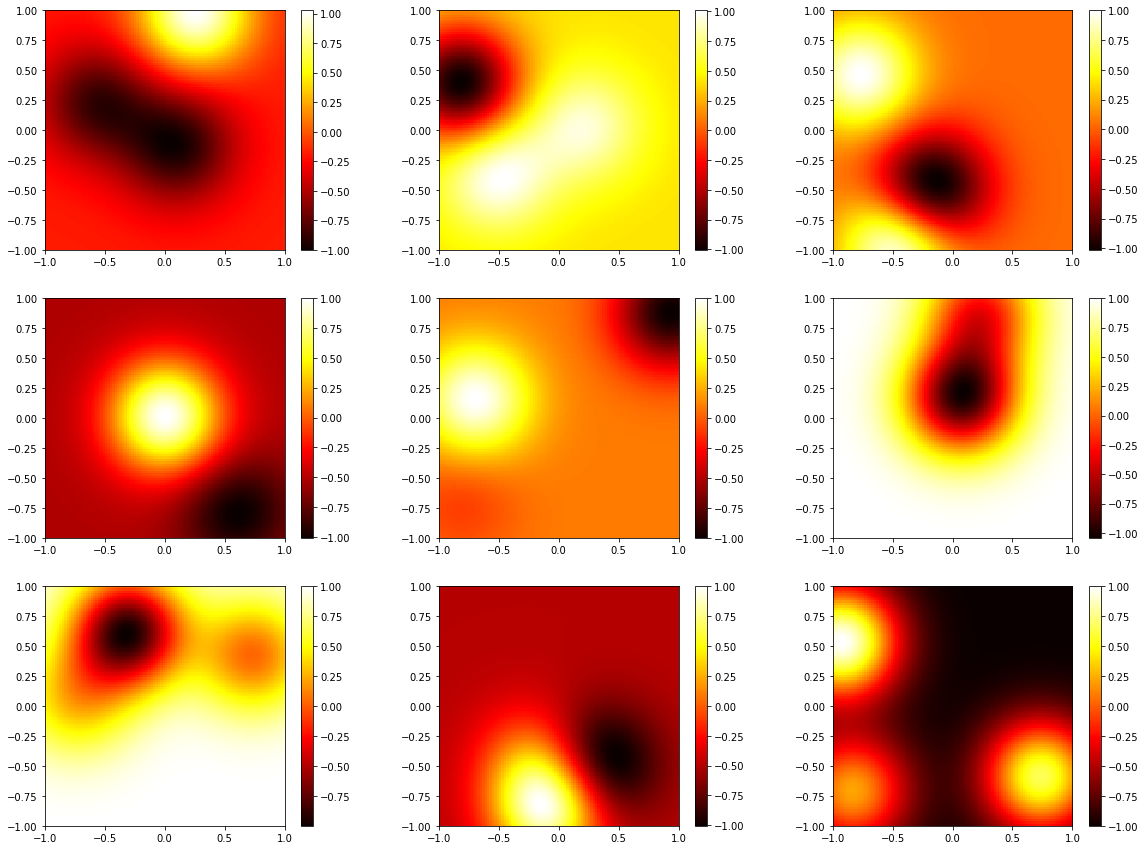

In [8]:
# Visualize Training Data
if visualize:
    nplot = 9
    idx = np.random.choice(list(range(n_train)), nplot)
    f_plot = lambda x: normalize(min_train[idx], max_train[idx], GP(X_train[idx], A_train[idx], x)) 
    viz.plot_training_data(f_plot, dim, nplot, heat = True)

In [9]:
# Create Model
size = tf.placeholder(tf.int32,[])

Xt = tf.placeholder(tf.float32, [None, n_bumps, dim])
At = tf.placeholder(tf.float32, [None, n_bumps, 1])
mint = tf.placeholder(tf.float32, [None, 1])
maxt = tf.placeholder(tf.float32, [None, 1])

f = lambda x: normalize(mint, maxt, GPTF(Xt, At, x)) 

# Create LSTM cell
cell = tf.contrib.rnn.LSTMCell(num_units = n_hidden, reuse=None)
cell(tf.zeros([size, dim +1]), (tf.zeros([size, n_hidden]),tf.zeros([size, n_hidden])), scope='rnn_cell')
cell = tf.contrib.rnn.LSTMCell(num_units = n_hidden, reuse=True)

# Create output weights
weights = {
    'W_x': tf.Variable(tf.random_normal([n_hidden, dim])),
    'b_x': tf.Variable(tf.random_normal([dim]))
}

samples_x, samples_y = lstm_model(f, cell, weights)

In [10]:
f_min = tf.reduce_mean(tf.reduce_min(samples_y, axis = 0))
loss_type = "WSUM_EXPO"
loss_dict = {"MIN" : lambda x : tf.reduce_mean(tf.reduce_min(x, axis = 0)), 
             "SUM" : lambda x : tf.reduce_mean(tf.reduce_sum(x, axis = 0)),
             "WSUM" : lambda x : \
             tf.reduce_mean(tf.reduce_sum(tf.multiply(x, np.linspace(1/(n_steps+1),1, n_steps+1)), axis = 0)),
             'WSUM_EXPO': lambda x: \
             tf.reduce_mean(tf.reduce_sum(tf.multiply(x, np.power(0.5,np.arange(1,n_steps+1)[::-1])), axis = 0)),
             "EI" : lambda x : tf.reduce_mean(tf.reduce_sum(x, axis = 0)) -\
                               tf.reduce_mean(tf.reduce_sum([tf.reduce_min(x[:i+1],\
                               axis = 0) for i in range(n_steps)], axis = 0))
            }
loss = loss_dict[loss_type](samples_y)

In [11]:
rate = tf.placeholder(tf.float32, [])
train_step = tf.train.AdamOptimizer(rate).minimize(loss)

In [12]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [13]:
train_logs = train_model(epochs, batch_size)

Function Dimension: 		2
Number of Training Samples: 	1600
Number of Test Samples: 	160
Batch size: 			128
Number of hidden Units: 	50
Sequence length: 		10
Noise in Observation: 		0.0
Loss-Function: 			WSUM_EXPO
Epochs: 			1000
Learning rate init: 		0.001
Learning rate decay: 		0.995405417351527
------------------------------------------------------------------------------------
Ep:    0 | TrainLoss: -0.124 | TrainMin: -0.420 | TestLoss: -0.141 | TestMin: -0.394
Ep:    1 | TrainLoss: -0.165 | TrainMin: -0.484 | TestLoss: -0.179 | TestMin: -0.485
Ep:    2 | TrainLoss: -0.181 | TrainMin: -0.470 | TestLoss: -0.223 | TestMin: -0.484
Ep:    3 | TrainLoss: -0.130 | TrainMin: -0.419 | TestLoss: -0.122 | TestMin: -0.394
Ep:    4 | TrainLoss: -0.149 | TrainMin: -0.464 | TestLoss: -0.139 | TestMin: -0.433
Ep:    5 | TrainLoss: -0.136 | TrainMin: -0.445 | TestLoss: -0.190 | TestMin: -0.484
Ep:    6 | TrainLoss: -0.178 | TrainMin: -0.535 | TestLoss: -0.195 | TestMin: -0.551
Ep:    7 | TrainLoss: -

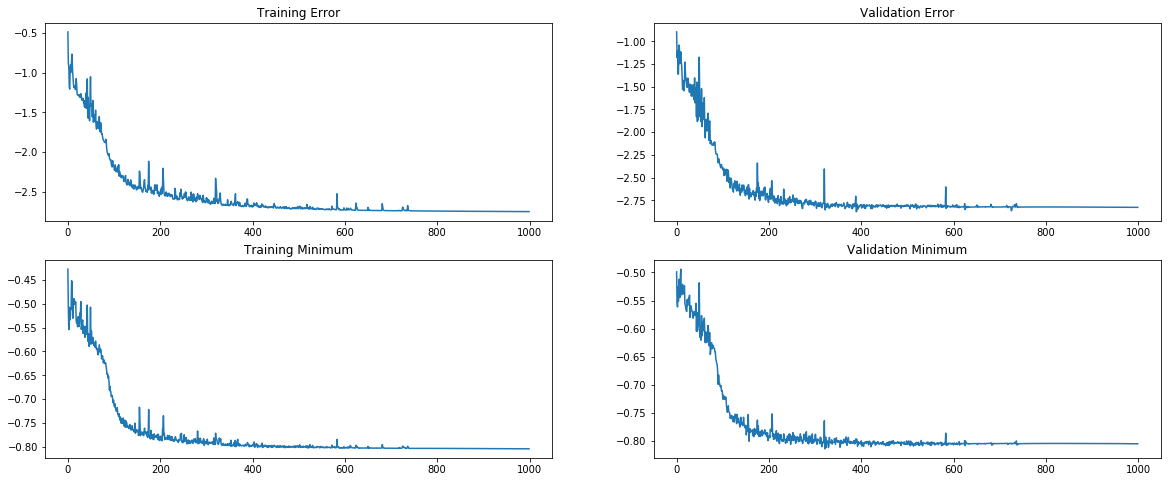

In [16]:
viz.visualize_learning(train_logs) # 'wsum'

## Evaluate on Training/Test Data

In [16]:
# Extract Samples
samples_train = sess.run([samples_x], feed_dict={Xt: X_train, At: A_train, size : n_train, mint: min_train, maxt: max_train})
samples_train = np.array(samples_train[0]).reshape(n_steps+1,n_train, dim).transpose((1,0,2))
samples_test = sess.run([samples_x], feed_dict={Xt: X_test, At: A_test, size : n_test, mint: min_test, maxt: max_test})
samples_test = np.array(samples_test[0]).reshape(n_steps+1,n_test, dim).transpose((1,0,2))

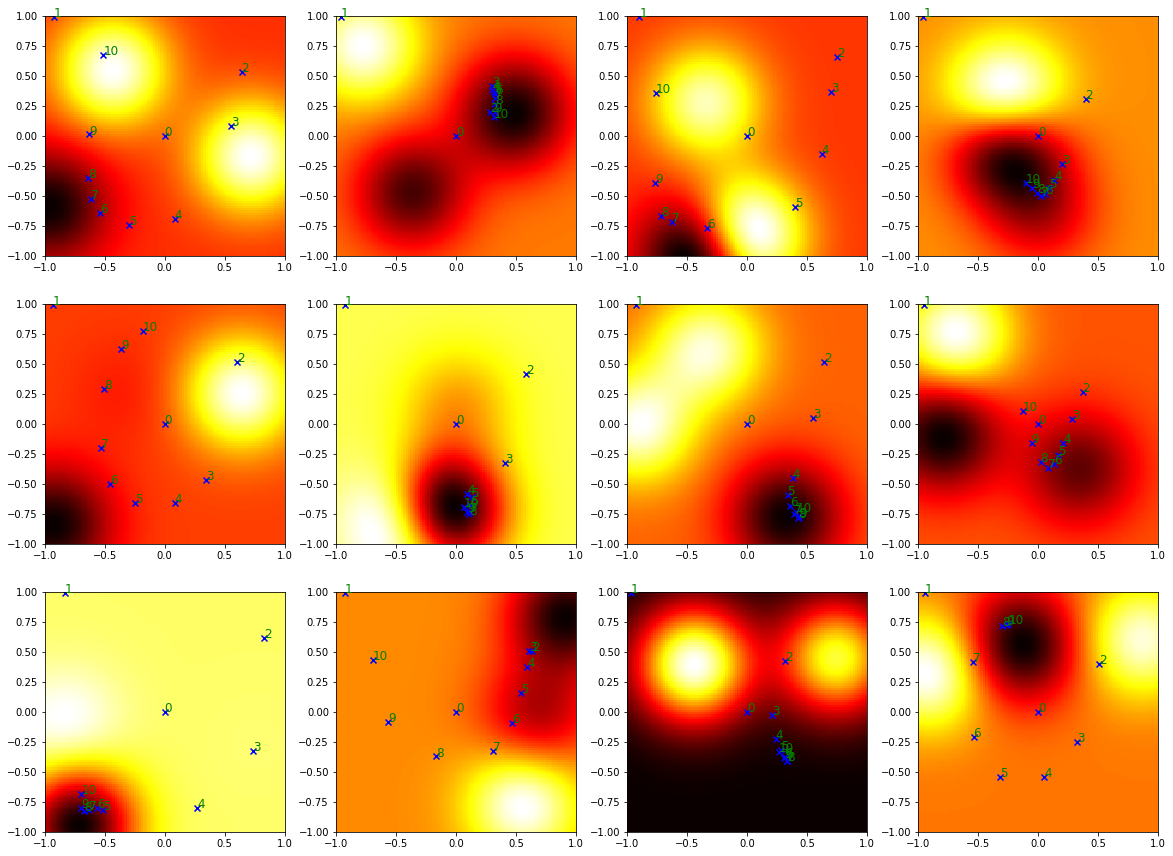

In [17]:
# Show results on Training Data
if visualize:
    nplot = 12
    idx = np.random.choice(list(range(n_train)), nplot)
    f_plot = lambda x: normalize(min_train[idx], max_train[idx], GP(X_train[idx], A_train[idx], x)) 
    viz.plot_result(f_plot, dim, nplot, samples_train[idx])

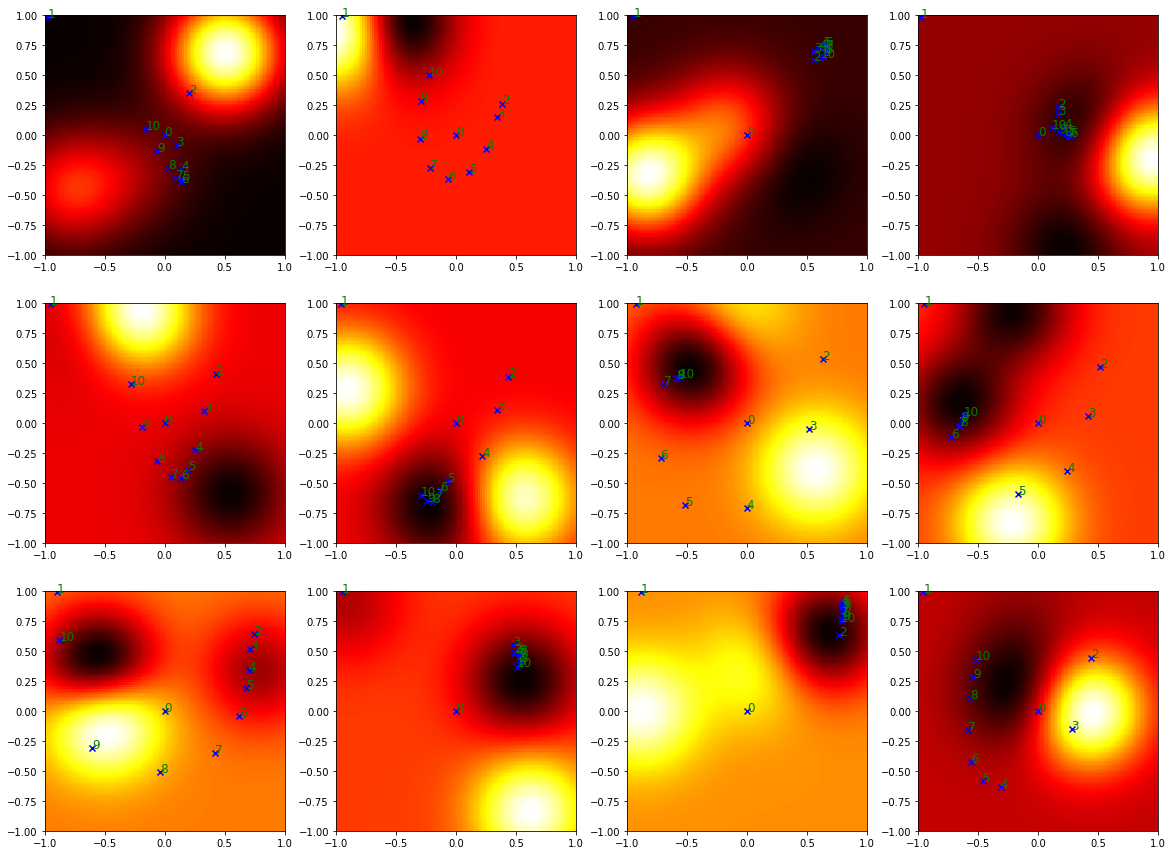

In [18]:
# Show results on Test Data
if visualize:
    nplot = 12
    idx = np.random.choice(list(range(n_test)), nplot)
    f_plot = lambda x: normalize(min_test[idx], max_test[idx], GP(X_test[idx], A_test[idx], x)) 
    viz.plot_result(f_plot, dim, nplot, samples_test[idx])

## Evaluate on Benchmark Function

In [2]:
def goldstein_price(x_1,x_2):
    #  https://www.sfu.ca/~ssurjano/goldpr.html
    # f(x*) = 3, x* = (0,-1) and x_i = [-2,2]
    y = (1 + (x_1 + x_2 + 1)**2 * (19 - 14*x_1 + 3*x_1**2 - 14*x_2 + 6*x_1*x_2+ 3*x_2**2))*\
    (30 + (2*x_1-3*x_2)**2 * (18 - 32*x_1 + 12*x_1**2 + 48*x_2 - 36*x_1*x_2+ 27*x_2**2))
    
    return y

In [3]:
goldstein_price(1.64587012,0)

600

In [ ]:
def plotGoldSteinEvaluation(sampling_points):
    xx_N = 100
    lin_range = 2
    xx_lin = np.linspace(-lin_range, lin_range, xx_N)
    yy_lin = np.linspace(-lin_range, lin_range, xx_N)
    xx_g, yy_g = np.meshgrid(xx_lin, yy_lin)
    vec_goldstein = np.vectorize(goldstein_price)

    z = np.log(vec_goldstein(xx_g, yy_g))

    plt.figure(figsize=(8,8))

    plt.contourf(xx_g, yy_g, z, cmap='hot')
#     plt.colorbar()

    plt.plot([0, 0], [-lin_range, lin_range], 'k-', lw=0.3)
    plt.plot([-lin_range, lin_range], [-1, -1], 'k-', lw=0.3)
    
    if len(sampling_points) > 0:
        plt.scatter(sampling_points[0,0], sampling_points[0,1], color = "k", marker = "o")

        for i in range(1,len(sampling_points)):
            prev = sampling_points[i-1]
            curr = sampling_points[i]
            plt.arrow(prev[0], prev[1], curr[0] - prev[0], curr[1] - prev[1], head_width=0.05, head_length=0.05, fc='k', ec='k')
            
    plt.title('GoldStein Function in Log-scale')

    plt.show()
    
sampling_data = np.array([(0,1), (-1,1), (0.8,1.5)])
plotGoldSteinEvaluation(sampling_data)

In [91]:
f_bm = [bf.branin, goldstein_price][1]
f_bm_tf = [bf.branin_tf, goldstein_price_tf][1]

In [92]:
samples_benchmark_x, _ = sess.run(lstm_model(f_bm_tf, cell, weights), feed_dict={size: 1})
samples_benchmark_x = np.array(samples_benchmark_x).reshape(n_steps+1,1, dim).transpose((1,0,2))

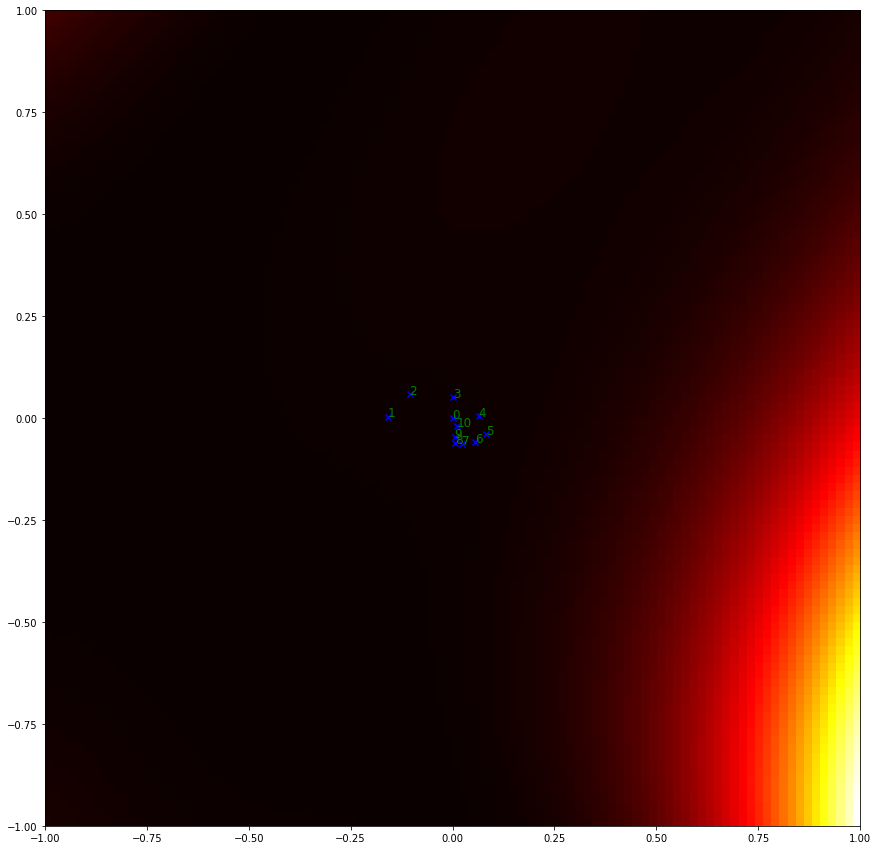

In [93]:
viz.plot_result(f_bm, 2, 1, samples_benchmark_x)

In [95]:
sx = np.array([[0,-1],[0,0]])
sx = samples_benchmark_x.reshape((11,2))
print(sx)
res = goldstein_price(sx).flatten()
# sorted_res = np.sort(res)
np.min(res)

[[-0.         -0.        ]
 [ 0.00389216 -0.15785383]
 [ 0.05972403 -0.10544922]
 [ 0.05196395  0.00111329]
 [ 0.00416074  0.0645428 ]
 [-0.03979901  0.08251471]
 [-0.059304    0.05578157]
 [-0.06425931  0.02329643]
 [-0.06119563  0.00659707]
 [-0.04745037  0.00536949]
 [-0.01964665  0.01112689]]


527.0545

In [4]:
goldstein_price(np.array([0,-1]))

NameError: name 'np' is not defined

In [3]:
def goldstein_price(x):
#     x = x*2
    
#     minv = 3
#     maxv = 1020000 
    x_1, x_2 = np.split(x,[1],axis=-1)
	
    y = (1 + (x_1 + x_2 + 1)**2 * (19 - 14*x_1 + 3*x_1**2 - 14*x_2 + 6*x_1*x_2+ 3*x_2**2))*\
    (30 + (2*x_1-3*x_2)**2 * (18 - 32*x_1 + 12*x_1**2 + 48*x_2 - 36*x_1*x_2+ 27*x_2**2))
    
    return y

In [2]:
def goldstein_price_tf(x):
    x = x*2
    
    minv = 3
    maxv = 1020000
    
    y = (1 + (x[:,0] + x[:,1] + 1)**2 * (19 - 14*x[:,0] + 3*x[:,0]**2 - 14*x[:,1] + 6*x[:,0]*x[:,1]\
                                             + 3*x[:,1]**2))*\
    (30 + (2*x[:,0]-3*x[:,1])**2 * (18 - 32*x[:,0] + 12*x[:,0]**2 + 48*x[:,1] - 36*x[:,0]*x[:,1]\
                                        + 27*x[:,1]**2))
    
    y = 2*(y-minv)/(maxv-minv)-1
    
    return tf.reshape(y, (-1,1))

In [102]:
start = 0.5
end = 0.125
ep = 10
decay = (end / start)** ( 1.0 / (ep-1) )
l = start
for i in range(10):
    print(l)
    l = l*decay

0.5
0.4286219914265364
0.3674336230688997
0.3149802624737183
0.2700149347230765
0.2314686780718226
0.19842513149602492
0.1700987500217971
0.14581612994701457
0.12499999999999999


In [104]:
a = 5
a *=2

In [105]:
a

10